In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
positive_dir = '/content/drive/MyDrive/Minor Project/DvXray_Positive_Samples'
negative_dir = '/content/drive/MyDrive/Minor Project/DvXray_Negative_Samples'


In [ ]:
# Set image size
img_size = 224

# Transform pipeline (you already defined this)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# Custom Dataset
class CargoDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder) if f.endswith(".png")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Instantiate Datasets
positive_dataset = CargoDataset(positive_dir, transform)
negative_dataset = CargoDataset(negative_dir, transform)


In [ ]:
class SiamesePairDataset(Dataset):
    def __init__(self, pos_dataset, neg_dataset, transform=None, num_pairs=1000):
        self.pos_dataset = pos_dataset
        self.neg_dataset = neg_dataset
        self.transform = transform
        self.num_pairs = num_pairs
        self.pairs = []
        self.labels = []

        # Build pairs
        self.create_pairs()

    def create_pairs(self):
        # Positive Pairs (same class)
        for _ in range(self.num_pairs // 2):
            if random.random() < 0.5:
                # positive-positive
                idx1, idx2 = random.sample(range(len(self.pos_dataset)), 2)
                img1 = self.pos_dataset[idx1]
                img2 = self.pos_dataset[idx2]
            else:
                # negative-negative
                idx1, idx2 = random.sample(range(len(self.neg_dataset)), 2)
                img1 = self.neg_dataset[idx1]
                img2 = self.neg_dataset[idx2]

            self.pairs.append((img1, img2))
            self.labels.append(1)

        # Negative Pairs (different class)
        for _ in range(self.num_pairs // 2):
            idx1 = random.randint(0, len(self.pos_dataset) - 1)
            idx2 = random.randint(0, len(self.neg_dataset) - 1)
            img1 = self.pos_dataset[idx1]
            img2 = self.neg_dataset[idx2]

            self.pairs.append((img1, img2))
            self.labels.append(0)

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        img1, img2 = self.pairs[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img1, img2, label

In [ ]:
# Create pair dataset
pair_dataset = SiamesePairDataset(positive_dataset, negative_dataset, transform, num_pairs=1000)

# Dataloader for training
pair_loader = DataLoader(pair_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=512):
        super(SiameseNetwork, self).__init__()
        resnet = models.resnet18(pretrained=True)
        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embedding_dim)

    def forward_once(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 14.9359, Accuracy: 50.00%
Epoch 2, Loss: 0.4670, Accuracy: 51.30%
Epoch 3, Loss: 0.3019, Accuracy: 55.40%
Epoch 4, Loss: 0.2654, Accuracy: 57.90%
Epoch 5, Loss: 0.2477, Accuracy: 60.80%
Epoch 6, Loss: 0.2343, Accuracy: 63.00%
Epoch 7, Loss: 0.2225, Accuracy: 66.60%
Epoch 8, Loss: 0.2139, Accuracy: 70.50%
Epoch 9, Loss: 0.2051, Accuracy: 72.00%
Epoch 10, Loss: 0.1963, Accuracy: 74.70%
Epoch 11, Loss: 0.1882, Accuracy: 76.70%
Epoch 12, Loss: 0.1789, Accuracy: 79.90%
Epoch 13, Loss: 0.1712, Accuracy: 81.20%
Epoch 14, Loss: 0.1603, Accuracy: 83.30%
Epoch 15, Loss: 0.1537, Accuracy: 84.70%
Epoch 16, Loss: 0.1441, Accuracy: 88.60%
Epoch 17, Loss: 0.1371, Accuracy: 87.80%
Epoch 18, Loss: 0.1268, Accuracy: 91.20%
Epoch 19, Loss: 0.1183, Accuracy: 92.80%
Epoch 20, Loss: 0.1103, Accuracy: 94.00%
Confusion Matrix (Final Epoch):
[[497   3]
 [ 57 443]]


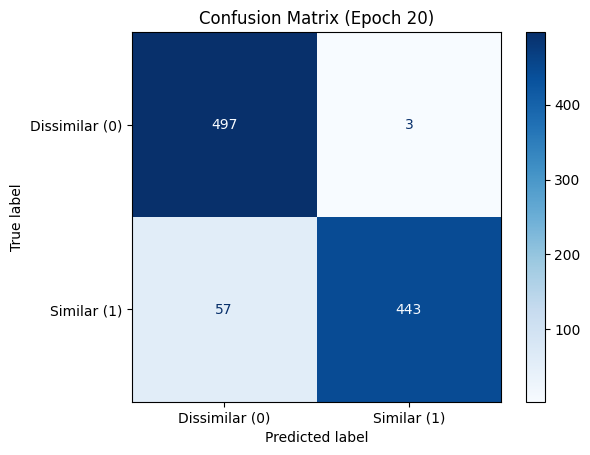

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

threshold = 0.5  # You can tune this

for epoch in range(20):  # Adjust epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    for img1, img2, label in pair_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        distance = F.pairwise_distance(output1, output2)
        predictions = (distance < threshold).float()

        correct += (predictions == label).sum().item()
        total += label.size(0)

        all_labels.extend(label.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

    accuracy = correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(pair_loader):.4f}, Accuracy: {accuracy*100:.2f}%")

    if epoch == 19:  # After final epoch (epoch 20)
        cm = confusion_matrix(all_labels, all_preds)
        print("Confusion Matrix (Final Epoch):")
        print(cm)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dissimilar (0)", "Similar (1)"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix (Epoch 20)")
        plt.show()
